In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/project2/recognition/17115001/IMG-20200728-WA0034.jpg
/kaggle/input/project2/recognition/17115001/IMG-20200728-WA0033.jpg
/kaggle/input/project2/recognition/17115001/IMG-20200728-WA0031.jpg
/kaggle/input/project2/recognition/17115001/IMG-20200728-WA0032.jpg
/kaggle/input/project2/recognition/17113241/IMG-20200719-WA0028.jpg
/kaggle/input/project2/recognition/17113241/IMG-20200719-WA0029.jpg
/kaggle/input/project2/recognition/17113242/IMG-20200719-WA0026.jpg
/kaggle/input/project2/recognition/17113242/IMG-20200719-WA0027.jpg
/kaggle/input/project2/recognition/17113242/IMG-20200719-WA0019.jpg
/kaggle/input/dddddddd/44316330.jpeg


In [2]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [3]:
training_set = train_datagen.flow_from_directory('/kaggle/input/project2/recognition/',
                                                 target_size = (100, 100),
                                                 batch_size = 10,
                                                 class_mode = 'categorical')

Found 9 images belonging to 3 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-01-04 08:00:58--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 173.194.218.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   150MB/s    in 0.6s    

2021-01-04 08:00:58 (150 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [6]:
local_weight_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [7]:
pretrained_model = InceptionV3(input_shape= (100,100,3),include_top = False,weights = None)

In [8]:
pretrained_model.load_weights(local_weight_file)

In [9]:
for layer in pretrained_model.layers:
    layer.trainable = False

In [10]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [11]:
last_layer = pretrained_model.get_layer('mixed8')
last_output = last_layer.output

In [12]:
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 1, 1, 1280)


In [13]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epochs,logs={}):
        if(logs.get('acc')>=0.90):
            print("\nReached 50% accuracy so cancelling training!")
            self.model.stop_training = True

In [14]:
from tensorflow.keras.optimizers import RMSprop
x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation = 'relu')(x)
x = layers.Dropout(.2)(x)
x = layers.Dense(3,activation ='softmax')(x)
model = Model(pretrained_model.input,x)

In [15]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=['acc'])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

activation_43 (Activation)      (None, 4, 4, 192)    0           batch_normalization_43[0][0]     
__________________________________________________________________________________________________
activation_48 (Activation)      (None, 4, 4, 192)    0           batch_normalization_48[0][0]     
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 4, 4, 192)    0           batch_normalization_49[0][0]     
__________________________________________________________________________________________________
mixed5 (Concatenate)            (None, 4, 4, 768)    0           activation_40[0][0]              
                                                                 activation_43[0][0]              
                                                                 activation_48[0][0]              
                                                                 activation_49[0][0]              
__________

In [17]:
my_callback_object = myCallback()
history = model.fit_generator(
    training_set,
    epochs=100, verbose =1,callbacks=[my_callback_object])

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 1.0467 - acc: 0.5556
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 2.1275 - acc: 0.4444
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.6586 - acc: 0.6667
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.7572 - acc: 0.6667
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.0530 - acc: 1.0000
Reached 50% accuracy so cancelling training!
1/1 [==============================] - 0s 2ms/step - loss: 0.0530 - acc: 1.0000


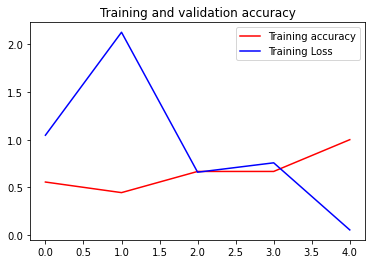

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, loss, 'r', label='Training Loss',c ='b')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [19]:
from keras.models import model_from_json
model1_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model1_json)
model.save_weights("model1.h5")

In [20]:
json_file = open('model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [21]:
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model1.h5")

In [22]:
loaded_model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=['acc'])

In [23]:
ans = loaded_model.predict(training_set)

In [24]:
import cv2
#checking
loaded_model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=['acc'])
img = cv2.imread('/kaggle/input/dddddddd/44316330.jpeg')

img = cv2.resize(img,(100,100))

img = np.reshape(img,[1,100,100,3])

classes = loaded_model.predict(img)

In [25]:
np.argmax(classes)

1